In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from matplotlib.path import Path
from itertools import product

from collections import defaultdict

In [3]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'
if not os.path.exists(volume_dir):
    os.makedirs(volume_dir)

In [4]:
##### reconstruct annotation volume ######

In [4]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

stack = 'MD589'
    
# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

93 368


In [5]:
username = 'yuncong'

In [7]:
from annotation_utilities import *
label_polygons = load_label_polygons_if_exists(stack, username, force=True)

username yuncong does not have any annotations for current section 93 
username yuncong does not have any annotations for current section 94 
username yuncong does not have any annotations for current section 95 
username yuncong does not have any annotations for current section 96 
username yuncong does not have any annotations for current section 97 
username yuncong does not have any annotations for current section 98 
username yuncong does not have any annotations for current section 99 
username yuncong does not have any annotations for current section 100 
username yuncong does not have any annotations for current section 101 
username yuncong does not have any annotations for current section 102 
username yuncong does not have any annotations for current section 103 
username yuncong does not have any annotations for current section 104 
username yuncong does not have any annotations for current section 105 
username yuncong does not have any annotations for current section 106 

In [8]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

colors = np.random.randint(0, 255, (len(labels_index), 3))

In [12]:
annotation_on_sections = get_annotation_on_sections(label_polygons=label_polygons, 
                                                    filtered_labels=labels_surroundIncluded)

landmark_range_limits = get_landmark_range_limits(stack=stack, label_polygons=label_polygons, 
                                                  filtered_labels=labels_surroundIncluded)

In [ ]:
# interpolate contour for between annotated sections

In [13]:
from shapely.geometry import Polygon, Point, LinearRing

def closest_to(point, poly):
    pol_ext = LinearRing(poly.exterior.coords)
    d = pol_ext.project(point)
    p = pol_ext.interpolate(d)
    closest_point_coords = list(p.coords)[0]
    return closest_point_coords

def interpolate_contours(cnt1, cnt2, nlevels):
    '''
    returned arrays include cnt1 and cnt2
    '''
    
    poly1 = Polygon(cnt1)
    poly2 = Polygon(cnt2)

    interpolated_cnts = np.empty((nlevels, len(cnt1), 2))
    for i, p in enumerate(cnt1):
        proj_point = closest_to(Point(p), poly2)
        interpolated_cnts[:, i] = (np.column_stack([np.linspace(p[0], proj_point[0], nlevels), 
                         np.linspace(p[1], proj_point[1], nlevels)]))
    
    return interpolated_cnts

In [118]:
# contour1 = find_contours(label_map_downsampled[150] == 1, .5)[0]
# contour2 = find_contours(label_map_downsampled[151] == 1, .5)[0]

In [122]:
# nlevels = 6
# interp_contours = interpolate_contours(contour1, contour2, nlevels)

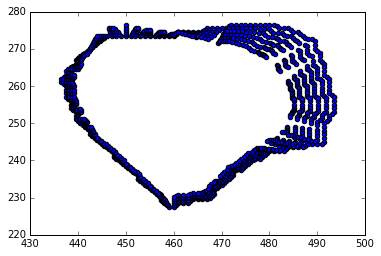

In [126]:
# for i in range(nlevels):
#     plt.scatter(interp_contours[i, :, 0], interp_contours[i, :, 1]);

In [29]:
# nlevels = 6
# interp_contours = interpolate_contours(contour1, contour2, nlevels)

In [14]:
mid_sec = (section_bs_begin + section_bs_end + 1)/2

In [17]:
interpolated_contours = [{} for _ in range(int(z_xy_ratio_downsampled*section_number_lookup[stack]))]

for l in set(label_polygons.keys()) & set(labels):
    secs = label_polygons[l].dropna().keys()
    if len(secs) < 2: continue
    
    print l

    for lims in landmark_range_limits[l]:
        considered_secs = sorted(set(range(lims[0], lims[1]+1)) & set(secs))
        n = len(considered_secs)
        for i in range(n):
            sec = considered_secs[i]            
            z0 = int(z_xy_ratio_downsampled*sec)
            interpolated_contours[z0][l] = label_polygons.loc[sec][l]            
            if i + 1 < n:
                next_sec = considered_secs[i+1]
                z1 = int(z_xy_ratio_downsampled*next_sec)
                interp_cnts = interpolate_contours(label_polygons.loc[sec][l], 
                                                   label_polygons.loc[next_sec][l],
                                                   z1-z0+1)
                for zi, z in enumerate(range(z0+1, z1)):
                    interpolated_contours[z][l] = interp_cnts[zi+1]

RtTg
Tz
VLL
7N
Amb
sp5
12N
AP
6N
5N
LRt
7n
R
Pn
LC


In [18]:
from skimage.measure import find_contours

In [21]:
import time

In [19]:
t = time.time()

dm = DataManager(stack=stack)

img_height_downsampled = dm.image_height/downsample_factor
img_width_downsampled = dm.image_width/downsample_factor

volume = np.zeros((img_height_downsampled, 
                   img_width_downsampled, 
                   int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.int8)

print volume.shape

for z in range(volume.shape[2]):
        
    if len(interpolated_contours[z]) == 0:
        continue
    
    label_map_downsampled = np.zeros((img_height_downsampled, img_width_downsampled), np.int8)
    
    for l, vs in interpolated_contours[z].iteritems():
        vs_downsampled = vs/downsample_factor
        
        xmin, ymin = np.min(vs_downsampled, axis=0).astype(np.int)
        xmax, ymax = np.max(vs_downsampled, axis=0).astype(np.int)
                
#         if xmin > img_width_downsampled-1 or ymin > img_height_downsampled-1:
#             print 'min coordinates exceed image boundary'
#             continue

        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(xmax, img_width_downsampled-1)
        ymax = min(ymax, img_height_downsampled-1)
        
#         points_to_test = np.array(list(product(range(ymin, ymax+1), range(xmin, xmax+1))))[:,::-1]
        xs, ys = np.meshgrid(range(xmin, xmax+1), range(ymin, ymax+1))
        points_to_test = np.c_[xs.flat, ys.flat]
                
        is_contained = Path(vs_downsampled).contains_points(points_to_test)
        label_map_downsampled[points_to_test[is_contained, 1], 
                              points_to_test[is_contained, 0]] = labels_index[l]
    
#     label_map_downsampled = label_map[::downsample_factor, ::downsample_factor]
    
    volume[:, :, z] = label_map_downsampled.copy()
    
    del label_map_downsampled
    
sys.stderr.write('build volume all: %.2f seconds\n' % (time.time() - t))

(734, 838, 1209)


In [118]:
# for z in range(volume.shape[2]):
#     if np.count_nonzero(volume[..., z] == 'LRt') > 0:
#         print z     

In [119]:
# print int(161*z_xy_ratio_downsampled), int(189*z_xy_ratio_downsampled)
# for z in range(int(161*z_xy_ratio_downsampled), int(189*z_xy_ratio_downsampled)):
#     print z, np.count_nonzero(volume[..., z] == label_dict['LRt'])

In [ ]:
# constant contour for between annotated sections

In [15]:
dm = DataManager(stack=stack)

volume = np.zeros((dm.image_height/downsample_factor, 
                   dm.image_width/downsample_factor, 
                   int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.int8)

print volume.shape

for sec in range(section_bs_begin, section_bs_end+1):
    
    if sec not in label_polygons.index: continue
    
    print sec
    
    available_labels = label_polygons.loc[sec].dropna().index
    
    valid_labels = set(available_labels) & set(labels)
    
    if len(valid_labels) == 0:
        continue
    
    label_map = np.zeros((dm.image_height, dm.image_width), np.int8)
    for l in valid_labels:
        print l
        
        import time
        t = time.time()
        
        vs = label_polygons[l][sec]
        xmin, ymin = np.min(vs, axis=0)
        xmax, ymax = np.max(vs, axis=0)
                
        if xmin > dm.image_width - 1 or ymin > dm.image_height - 1:
            print 'min coordinates exceed image boundary'
            continue
        
        xmax = min(xmax, dm.image_width-1)
        ymax = min(ymax, dm.image_height-1)
        
#         points_to_test = np.array(list(product(range(ymin, ymax+1), range(xmin, xmax+1))))[:,::-1]
        xs, ys = np.meshgrid(range(xmin, xmax+1), range(ymin, ymax+1))
        points_to_test = np.c_[xs.flat, ys.flat]
        
        print time.time() - t
        
        is_contained = Path(vs).contains_points(points_to_test)
        label_map[points_to_test[is_contained, 1], points_to_test[is_contained, 0]] = labels_index[l]
    
    label_map_downsampled = label_map[::downsample_factor, ::downsample_factor]
    
    volume[:, :, int(z_xy_ratio_downsampled*sec):int(z_xy_ratio_downsampled*(sec+1))] = label_map_downsampled[..., np.newaxis].copy()
    
    del label_map_downsampled, label_map

(734, 838, 1209)
110
111
113
115
117
119
121
123
125
127
129
131
sp5
133
sp5
135
sp5
137
sp5
139
sp5
141
sp5
143
VLL
sp5
145
VLL
sp5
147
sp5
VLL
149
7n
VLL
sp5
150
7n
5N
VLL
151
7n
5N
VLL
sp5
152
7N
5N
VLL
7n
153
7n
7N
5N
VLL
sp5
154
VLL
7N
sp5
LVe
5N
7n
155
VLL
7N
SuVe
sp5
LVe
5N
7n
156
VLL
7N
sp5
LVe
5N
7n
157
VLL
7N
SuVe
sp5
LVe
5N
7n
158
VLL
7N
sp5
LVe
5N
7n
159
VLL
7n
7N
sp5
LVe
5N
SuVe
160
VLL
7n
7N
sp5
LVe
5N
SuVe
161
VLL
7n
7N
sp5
LVe
5N
LRt
SuVe
162
VLL
7N
sp5
LVe
5N
LRt
7n
163
VLL
7n
7N
sp5
LVe
5N
LRt
SuVe
164
VLL
7N
Amb
sp5
LVe
5N
LRt
7n
165
VLL
7N
Amb
sp5
LVe
5N
LRt
7n
SuVe
166
VLL
7N
Amb
sp5
LVe
5N
LRt
7n
SuVe
167
VLL
7N
Amb
sp5
LVe
5N
LRt
7n
SuVe
168
VLL
7N
Amb
sp5
LVe
5N
LRt
7n
169
VLL
7N
Amb
sp5
LVe
5N
LRt
7n
SuVe
170
VLL
7N
Amb
sp5
LVe
5N
LRt
7n
171
VLL
7N
sp5
LVe
5N
LRt
7n
172
VLL
7N
sp5
LVe
LRt
7n
173
VLL
7N
sp5
LVe
LRt
7n
174
7N
LRt
sp5
7n
175
LC
7N
sp5
LVe
LRt
7n
Pn
176
LC
7n
sp5
LRt
7N
Pn
177
LC
7n
sp5
LRt
7N
Pn
178
LC
7n
sp5
LRt
7N
Pn
179
LC
7n
sp5
LRt
7N
Pn
180


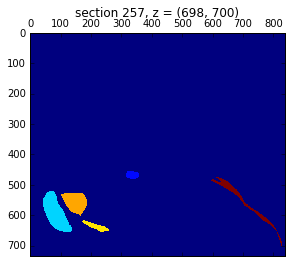

In [22]:
# for sec in range(section_bs_begin, section_bs_end+1):

sec = 257
plt.matshow(volume[..., int(sec*z_xy_ratio_downsampled)]);
plt.title('section %d, z = (%d, %d)'%(sec, int(sec*z_xy_ratio_downsampled), 
                                     int(z_xy_ratio_downsampled*(sec+1))-1));
plt.show();

In [23]:
ys, xs, zs = np.where(volume != 0)

xmin = xs.min()
xmax = xs.max()
ymin = ys.min()
ymax = ys.max()
zmin = zs.min()
zmax = zs.max()

print xmin, xmax
print ymin, ymax
print zmin, zmax

reduced_xdim = xmax+1-xmin
reduced_ydim = ymax+1-ymin
reduced_zdim = zmax+1-zmin
print reduced_xdim, reduced_ydim, reduced_zdim

28 837
329 733
355 888
810 405 534


In [24]:
bp.pack_ndarray_file(volume[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1],
                     os.path.join(volume_dir, 'volume_%(stack)s_annotation.bp' % {'stack': stack}))

In [25]:
with open(os.path.join(volume_dir, 'volume_%(stack)s_annotation_limits.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%d']*6)+'\n') % (xmin, xmax, ymin, ymax, zmin, zmax))

In [26]:
with open(os.path.join(volume_dir, 'volume_%(stack)s_annotation_resolution.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%f']*3)+'\n') % (downsample_factor, xy_pixel_distance_downsampled, z_xy_ratio_downsampled))